#connecting to google drive

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [2]:
!pip install gensim
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=066cc9b677fea92207d872dc224a37dcde826930281bfdc32ae687af02854a3a
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [3]:
import gensim
import gensim.corpora as corpora
import pandas as pd
import spacy
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap
from collections import Counter

In [4]:
import os

DATA_DIR = "./gdrive/MyDrive/Topic-Modeling/dataset/disaster-tweet"
OUT_DIR = "./gdrive/MyDrive/Topic-Modeling/output/disaster-tweet"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok = True)

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR, exist_ok = True)

#loading dataset (one-time only)


In [ ]:
#! mkdir ~/.kaggle

In [ ]:
#! cp ./gdrive/MyDrive/Topic-Modeling/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download -c nlp-getting-started
#! mkdir -p ./gdrive/MyDrive/Topic-Modeling/dataset
#! unzip nlp-getting-started.zip -d ./gdrive/MyDrive/Topic-Modeling/dataset/disaster-tweet

#data pre-processing

In [ ]:
df = pd.read_csv(DATA_DIR + "/train.csv")
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.dropna(subset=['text'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
import re

def preprocess(text):
    no_punct = re.sub(r'[^\w\s]', '', text)
    return no_punct.lower()

def lemmatize(texts):

    result = []

    for doc in nlp.pipe(texts):
        lemma_text = " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_stop and len(token) > 1 ])
        result.append(lemma_text.lower())

    return result

In [ ]:
lemmatized_text = lemmatize(df['text'].tolist())
lemmatized_text

['deed reason earthquake allah forgive',
 'forest fire near la ronge sask canada',
 'resident ask shelter place notify officer evacuation shelter place order expect',
 '13,000 people receive wildfire evacuation order california',
 'got send photo ruby alaska smoke wildfire pour school',
 'rockyfire update california hwy 20 close direction lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flooding street manitou colorado springs area',
 'hill fire wood',
 'emergency evacuation happen building street',
 'afraid tornado come area',
 'people die heat wave far',
 'haha south tampa getting flood hah- wait second live south tampa gonna gonna fvck flood',
 'rain flood florida tampabay tampa 18 19 day lose count',
 'flood bago myanmar arrive bago',
 'damage school bus 80 multi car crash breaking',
 'man',
 'love fruit',
 'summer lovely',
 'car fast',
 'goooooooaaaaaal',
 'ridiculous',
 'london cool',
 'love skiing',
 'wonderful day',
 'looooool',
 'way eat shit',
 'nyc 

In [ ]:
df["processed_text"] = lemmatized_text
df.to_csv(DATA_DIR + "/processed.csv")

#topic modeling using LDA

In [ ]:
df = pd.read_csv(DATA_DIR + "/processed.csv")
df

,Unnamed: 0,id,keyword,location,text,target,processed_text
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfire evacuation orde..."
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...
7608,7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home h...
7609,7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @thetawniest control wild fire ca...
7610,7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 01:04 utc]?5 km volcano hawaii http://t....
7611,7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigate bike collide car little por...


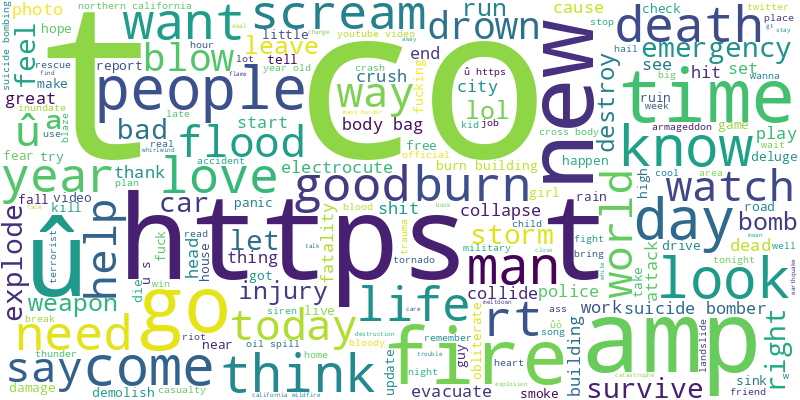

In [ ]:
from wordcloud import WordCloud
# Join the different processed titles together.

long_string = ','.join(list(df['processed_text'].values))

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# Create a corpus dictonary using corpora
words = [doc.split() for doc in df['processed_text'] ]

id2word = corpora.Dictionary(words)

# Term-Document Frequency
corpus = [id2word.doc2bow(text) for text in words]

corpus[:3]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 2)]]

In [ ]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, passes = 20)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

doc_lda = lda_model[corpus]

[(0,
  '0.012*"like" + 0.009*"fire" + 0.006*"flood" + 0.006*"smoke" + 0.006*"amp" + '
  '0.006*"shit" + 0.006*"thunderstorm" + 0.006*"look" + 0.005*"year" + '
  '0.005*"change"'),
 (1,
  '0.009*"family" + 0.009*"wildfire" + 0.008*"home" + 0.007*"legionnaires" + '
  '0.007*"weather" + 0.007*"issue" + 0.006*"severe" + 0.006*"california" + '
  '0.005*"ok" + 0.005*"late"'),
 (2,
  '0.016*"disaster" + 0.008*"hiroshima" + 0.008*"obama" + 0.007*"nuclear" + '
  '0.006*"weapon" + 0.006*"movie" + 0.005*"year" + 0.005*"time" + 0.005*"sink" '
  '+ 0.005*"love"'),
 (3,
  '0.011*"wound" + 0.009*"body" + 0.009*"like" + 0.006*"trauma" + 0.006*"fire" '
  '+ 0.006*"suspect" + 0.006*"bag" + 0.006*"police" + 0.005*"good" + '
  '0.005*"zone"'),
 (4,
  '0.008*"attack" + 0.006*"trap" + 0.005*"police" + 0.005*"school" + '
  '0.005*"train" + 0.005*"post" + 0.005*"car" + 0.005*"bus" + 0.004*"rise" + '
  '0.004*"derail"'),
 (5,
  '0.018*"suicide" + 0.010*"bomber" + 0.009*"mh370" + 0.008*"crash" + '
  '0.008*"bom

In [ ]:
import numpy as np

def get_document_topic_lda(model, corpus, k):
   n_doc = len(corpus)
   #init a vector of size number of docs x clusters
   document_topic_mapping = np.zeros((n_doc, k))
   for i in range(n_doc):
     # for each document create a vector of probability document belonging to topic
     for topic, prob in model.get_document_topics(corpus[i]):
       document_topic_mapping[i, topic] = prob

   return document_topic_mapping

In [ ]:
embedding_lda = get_document_topic_lda(lda_model, corpus, num_topics)

print("Embedding vector shape :", embedding_lda.shape)
embedding_lda

Embedding vector shape : (7613, 10)


array([[0.34879735, 0.01670686, 0.35053486, ..., 0.01670566, 0.01670566,
        0.01671069],
       [0.01252734, 0.41817924, 0.01252498, ..., 0.01252778, 0.01252663,
        0.01253047],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0125054 , 0.0125054 , 0.01250546, ..., 0.01250563, 0.0125054 ,
        0.0125054 ],
       [0.        , 0.        , 0.93997484, ..., 0.        , 0.        ,
        0.        ],
       [0.01000112, 0.90998667, 0.01000165, ..., 0.01000117, 0.01000154,
        0.01000162]])

In [ ]:
for i,topic in enumerate(embedding_lda[num_topics].flatten()):
    print(f"Topic {i + 1} : ", embedding_lda[num_topics].flatten()[i])

Topic 1 :  0.016671206802129745
Topic 2 :  0.01667020097374916
Topic 3 :  0.4446454346179962
Topic 4 :  0.016673369333148003
Topic 5 :  0.016671840101480484
Topic 6 :  0.016669416800141335
Topic 7 :  0.01667160913348198
Topic 8 :  0.016673946753144264
Topic 9 :  0.016670415177941322
Topic 10 :  0.42198261618614197


In [ ]:
srtd = sorted( lda_model.get_document_topics(corpus[0]) , key=lambda x: x[1], reverse=True)
print(srtd[0][0])
srtd

2


[(2, 0.3505342),
 (0, 0.3487973),
 (6, 0.18371198),
 (5, 0.016711988),
 (9, 0.016711101),
 (4, 0.016709253),
 (1, 0.016706867),
 (3, 0.016705938),
 (7, 0.01670567),
 (8, 0.01670567)]

In [ ]:
labels_lda = []

for line in corpus :
  line_labels = sorted( lda_model.get_document_topics(line) , key=lambda x: x[1], reverse=True)

  #1st 0 is for selecting top item, and 2nd 0 is for index of tuple
  top_topic = line_labels[0][0]

  labels_lda.append(top_topic)

In [ ]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=words, dictionary=id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score of LDA  : ', coherence_lda)
print("Silhouette score of LDA : ", silhouette_score(embedding_lda, labels_lda))

Coherence Score of LDA  :  0.4130552360623014
Silhouette score of LDA :  0.5774411223179466


In [ ]:
def getLabels(model, corpus):
    labels = []

    for line in corpus :
        line_labels = sorted(model.get_document_topics(line) , key=lambda x: x[1], reverse=True)

        #1st 0 is for selecting top item, and 2nd 0 is for index of tuple
        top_topic = line_labels[0][0]

        labels.append(top_topic)
    return labels

def getMetrics(model, words, dict, corpus, num_topics):
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    embedding_lda = get_document_topic_lda(model, corpus, num_topics)
    labels_lda = getLabels(model, corpus)

    # print('Coherence Score of LDA  : ', coherence_lda)
    # print("Silhouette score of LDA : ", silhouette_score(embedding_lda, labels_lda))

    return coherence_lda, silhouette_score(embedding_lda, labels_lda)

In [ ]:
getMetrics(lda_model, words, id2word, corpus, num_topics)

(0.4130552360623014, 0.5776679761085195)

#hyper-parameter tuning

In [ ]:
import numpy as np
import tqdm
import gensim
import pandas as pd

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs * 0.75)),
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Sihouette Score': []
                 }

total_iterations = (len(topics_range))
pbar = tqdm.tqdm(total=total_iterations)

for i, corpus in enumerate(corpus_sets):
    for k in topics_range:
        for a in alpha:
            for b in beta:
                model = gensim.models.LdaMulticore(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=k, passes=20, alpha=a, eta=b)

                # Convert ClippedCorpus to list
                corpus_list = list(corpus)

                # get the coherence score for the given parameters
                coherence, silhouette = getMetrics(model, words, id2word, corpus_list, k)

                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(coherence)
                model_results['Sihouette Score'].append(silhouette)

                pbar.update(1)

                # Check if 18/18 iterations are complete
                if pbar.n >= total_iterations:
                    break

    # Check if 18/18 iterations are complete
    if pbar.n >= total_iterations:
        break

pd.DataFrame(model_results).to_csv(OUT_DIR + '/lda_tuning_results.csv', index=False)
pbar.close()



  0%|          | 1/1080 [01:45<31:45:28, 105.96s/it]

100%|██████████| 18/18 [05:44<00:00, 19.95s/it]
19it [06:04, 19.84s/it]                        
20it [06:21, 19.04s/it]
21it [06:36, 17.91s/it]
22it [06:55, 18.21s/it]
23it [07:13, 18.19s/it]
24it [07:30, 17.83s/it]
25it [07:49, 18.07s/it]
26it [08:07, 18.10s/it]
27it [08:23, 17.40s/it]
28it [08:44, 18.38s/it]
29it [09:02, 18.49s/it]
30it [09:19, 17.97s/it]
31it [09:38, 18.21s/it]
32it [09:57, 18.34s/it]
33it [10:13, 17.61s/it]
34it [10:32, 18.32s/it]
35it [10:52, 18.76s/it]
36it [11:10, 18.32s/it]
37it [11:28, 18.39s/it]
38it [11:46, 18.28s/it]
39it [12:02, 17.69s/it]
40it [12:21, 18.06s/it]
41it [12:39, 18.04s/it]
42it [12:57, 17.92s/it]
43it [13:17, 18.56s/it]
44it [13:36, 18.79s/it]
45it [13:53, 18.14s/it]
46it [14:12, 18.52s/it]
47it [14:31, 18.43s/it]
48it [14:47, 17.92s/it]
49it [15:05, 17.80s/it]
50it [15:22, 17.72s/it]
51it [15:38, 17.19s/it]
52it [16:00, 18.50s/it]
53it [16:18, 18.41s/it]
54it [16:34, 17.75s/it]
55it [16:

In [9]:
model_results = pd.read_csv(OUT_DIR + '/lda_tuning_results.csv')
model_results = model_results.drop(["Validation_Set", "Coherence"], axis = 1)

model_results.head()

,Topics,Alpha,Beta,Sihouette Score
0,2,0.01,0.01,0.960812
1,2,0.01,0.31,0.980253
2,2,0.01,0.61,0.986571
3,2,0.01,0.9099999999999999,0.993920
4,2,0.01,symmetric,0.986863


In [10]:
model_results

,Topics,Alpha,Beta,Sihouette Score
0,2,0.01,0.01,0.960812
1,2,0.01,0.31,0.980253
2,2,0.01,0.61,0.986571
3,2,0.01,0.9099999999999999,0.993920
4,2,0.01,symmetric,0.986863
...,...,...,...,...
117,19,0.31,0.01,0.591278
118,19,0.61,0.01,0.200455
119,19,0.9099999999999999,0.01,0.129104
120,19,symmetric,0.01,0.820990


from matplotlib import pyplot as plt
model_results['Topics'].plot(kind='hist', bins=20, title='Topics')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_results['Sihouette Score'].plot(kind='hist', bins=20, title='Sihouette Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
model_results.groupby('Alpha').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
model_results.groupby('Beta').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
model_results.plot(kind='scatter', x='Topics', y='Sihouette Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Topics']
  ys = series['Sihouette Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_results.sort_values('Topics', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Alpha')):
  _plot_series(series, series_name, i)
  fig.legend(title='Alpha', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topics')
_ = plt.ylabel('Sihouette Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Topics']
  ys = series['Sihouette Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_results.sort_values('Topics', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Beta')):
  _plot_series(series, series_name, i)
  fig.legend(title='Beta', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topics')
_ = plt.ylabel('Sihouette Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Topics']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Topics'}, axis=1)
              .sort_values('Topics', ascending=True))
  xs = counted['Topics']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_results.sort_values('Topics', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Alpha')):
  _plot_series(series, series_name, i)
  fig.legend(title='Alpha', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topics')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Topics']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Topics'}, axis=1)
              .sort_values('Topics', ascending=True))
  xs = counted['Topics']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_results.sort_values('Topics', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Beta')):
  _plot_series(series, series_name, i)
  fig.legend(title='Beta', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topics')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
model_results['Topics'].plot(kind='line', figsize=(8, 4), title='Topics')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
model_results['Sihouette Score'].plot(kind='line', figsize=(8, 4), title='Sihouette Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Beta'].value_counts()
    for x_label, grp in model_results.groupby('Alpha')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Alpha')
_ = plt.ylabel('Beta')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_results['Alpha'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_results, x='Topics', y='Alpha', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_results['Beta'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_results, x='Topics', y='Beta', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_results['Alpha'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_results, x='Sihouette Score', y='Alpha', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(model_results['Beta'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(model_results, x='Sihouette Score', y='Beta', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

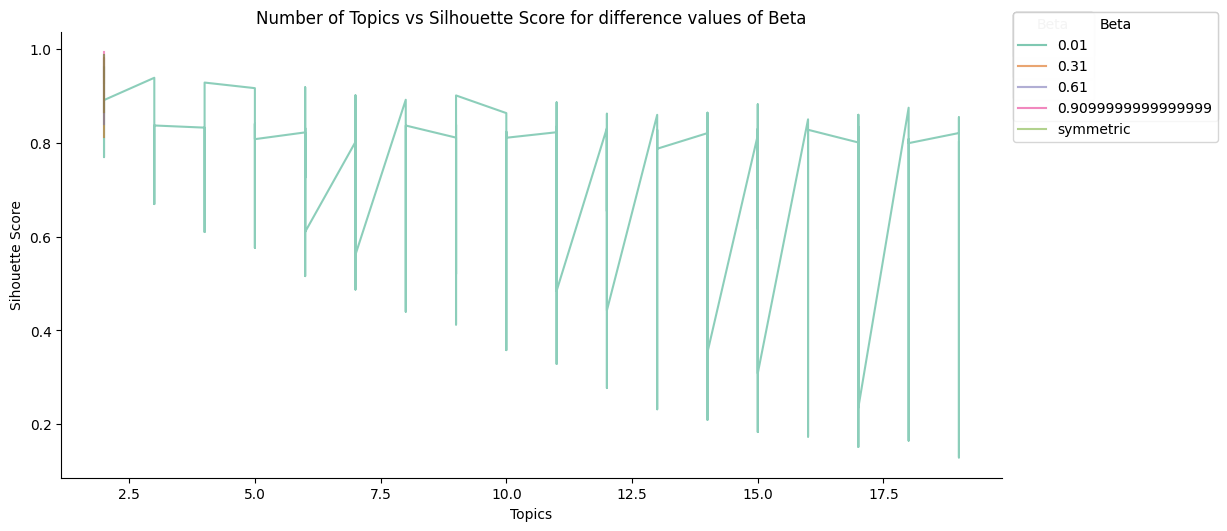

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Topics']
  ys = series['Sihouette Score']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)], alpha = .5)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_results.sort_values('Topics', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Beta')):
  _plot_series(series, series_name, i)
  fig.legend(title='Beta', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topics')

plt.title('Number of Topics vs Silhouette Score for difference values of Beta')

_ = plt.ylabel('Sihouette Score')

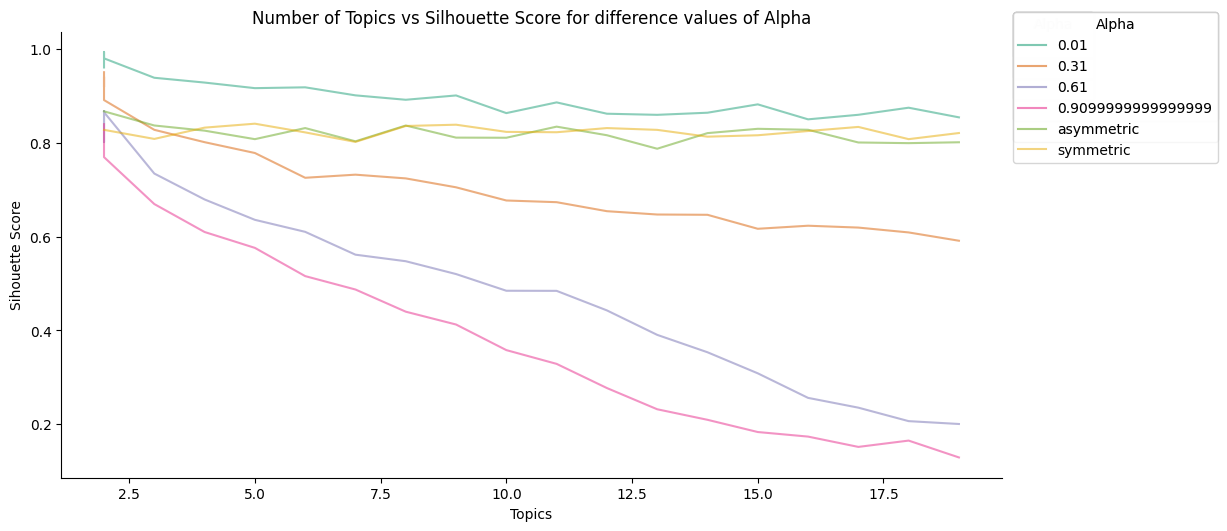

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Topics']
  ys = series['Sihouette Score']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)], alpha = .5)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = model_results.sort_values('Topics', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Alpha')):
  _plot_series(series, series_name, i)
  fig.legend(title='Alpha', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)

plt.xlabel('Topics')
plt.title('Number of Topics vs Silhouette Score for difference values of Alpha')


_ = plt.ylabel('Sihouette Score')

In [23]:
model_results_sort = model_results.sort_values(by = 'Sihouette Score')
model_results_sort

,Topics,Alpha,Beta,Sihouette Score
119,19,0.9099999999999999,0.01,0.129104
107,17,0.9099999999999999,0.01,0.151586
113,18,0.9099999999999999,0.01,0.165046
101,16,0.9099999999999999,0.01,0.173576
95,15,0.9099999999999999,0.01,0.183313
...,...,...,...,...
0,2,0.01,0.01,0.960812
1,2,0.01,0.31,0.980253
2,2,0.01,0.61,0.986571
4,2,0.01,symmetric,0.986863


#LDA visualization

In [ ]:
!pip install pyLDAvis
!pip install pandas==1.5.3

import pyLDAvis
import pyLDAvis.gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 33.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
pyLDAvis.enable_notebook()

LDA_VIS_PATH = OUT_DIR + f"/lda"

if not os.path.exists(LDA_VIS_PATH):
    os.makedirs(LDA_VIS_PATH, exist_ok = True)

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDA_VIS_PATH + f"/{num_topics}.dat", 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDA_VIS_PATH + f"/{num_topics}.dat", 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, LDA_VIS_PATH + f"/{num_topics}.html")

LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.040176  0.086777       1        1  14.604438
7      0.034969 -0.025011       2        1  10.582847
9      0.076046 -0.081341       3        1  10.200103
6      0.023397 -0.043017       4        1   9.848279
0      0.022750 -0.071536       5        1   9.808917
2      0.013195 -0.114081       6        1   9.772180
4      0.008132 -0.014850       7        1   9.719973
1     -0.030022  0.040380       8        1   8.977536
5     -0.271162  0.026378       9        1   8.292863
8      0.082521  0.196301      10        1   8.192866, topic_info=          Term       Freq      Total Category  logprob  loglift
763      wreck  20.000000  20.000000  Default  30.0000  30.0000
46    disaster  19.000000  19.000000  Default  29.0000  29.0000
2010   suicide  18.000000  18.000000  Default  28.0000  28.0000
3594     wound  20.000000  20.000000  Default  27.0000  27.0000
953       body  20.000000  20.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
61        come   3.762723  22.012772  Topic10  -5.5864   0.7354
953       body   3.567613  20.145332  Topic10  -5.6396   0.7708
4841    rescue   3.128227  10.494399  Topic10  -5.7711   1.2915
595       good   3.248497  23.090310  Topic10  -5.7333   0.5407
209       life   3.122916  15.531179  Topic10  -5.7728   0.8978

[640 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
19759      7  0.909900    -10:00
19760      7  0.909900  01:04:01
1293       4  0.352206        05
1293       6  0.176103        05
1293       8  0.528309        05
...      ...       ...       ...
1292       6  0.124156        û
1292       7  0.372468        û
1292       8  0.124156        û
1292       9  0.248312        û
19046     10  0.837977   ûïwhen

[1128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 10, 7, 1, 3, 5, 2, 6, 9])

#bert modeling

In [ ]:
!pip install sentence-transformers transformers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=62e5a40dc286017a0a1e37eb66ce903a3cd79414d2a401e9d56ff018398b0f4c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('bert-base-nli-max-tokens')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


.gitattributes:   0%|          | 0.00/391 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
embedding_bert = np.array(model_bert.encode(df['processed_text'], show_progress_bar=True))
embedding_bert

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batches:   0%|          | 0/238 [00:00<?, ?it/s]

array([[ 0.773405  ,  1.2977313 ,  1.2123203 , ...,  0.70904505,
         0.57678044,  0.20446147],
       [ 0.8155561 ,  1.626805  ,  0.00318024, ...,  0.10040838,
         0.85426503,  0.38794944],
       [ 0.8019675 ,  0.74711573,  1.9808565 , ...,  0.46847367,
        -0.3418382 , -0.11295634],
       ...,
       [ 1.1307914 ,  1.1351069 ,  0.47887668, ..., -0.298322  ,
         1.6904954 ,  0.46993452],
       [ 0.5724378 ,  0.1375352 ,  0.74585485, ..., -0.2620469 ,
         0.27115583, -0.28203863],
       [ 1.1542606 ,  0.8421084 ,  0.9066168 , ..., -0.43171248,
         1.5766432 , -0.14331011]], dtype=float32)

In [ ]:
from sklearn.cluster import KMeans

# Choose the number of clusters (topics)
num_clusters = 5

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embedding_bert)

# Get cluster labels
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7cef0b3d97e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/thread

In [ ]:
texts = df['processed_text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in range(num_clusters):
    cluster_indices = [idx for idx, label in enumerate(cluster_labels) if label == i]
    cluster_sentences = [texts[idx] for idx in cluster_indices]
    print(f"Cluster {i + 1}: {cluster_sentences}")

Cluster 1: ['check http://t.co/roi2nsmejj http://t.co/3tj8zjin21 http://t.co/yduixefipe http://t.co/lxtjc87kl nsfw', 'gain follower week know stat grow http://t.co/tiyulif5c6', 'check http://t.co/roi2nsmejj http://t.co/3tj8zjin21 http://t.co/yduixefipe http://t.co/lxtjc87kl nsfw', 'santa cruz \x89ûó head st elizabeth police superintendent lanford salmon http://t.co/vplr5hka2u http://t.co/sxhw2tnnlf', 'noches el bestia @alexis_sanchez happy teammate train hard goodnight gunner http://t.co/uc4j4jhvgr', 'set heart ablaze city gift skyline like kiss lip @\x89û https://t.co/cyompz1a0z', 'nowplaying rene ablaze amp ian buff magnitude http://t.co/av2jsjfftc edm', 'accident i-24 nashvilletraffic traffic move slow usual https://t.co/0ghk693egj', 'accident center lane block santaclara us-101 nb great america pkwy bayarea traffic http://t.co/pmlohzurwr', 'http://t.co/gkye6gjtk5 personalinjury accident summer read advice amp solicitor help otleyhour', 'accident know gon happen https://t.co/ysxun5v

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


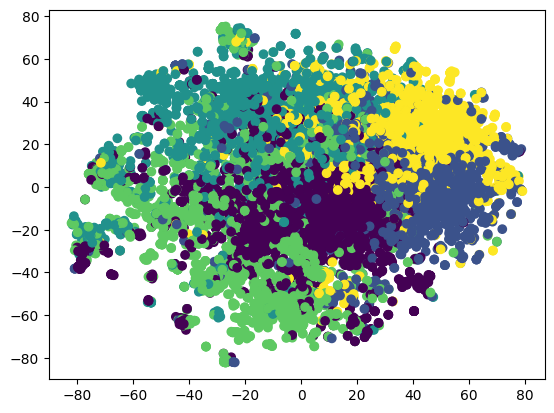

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap
from collections import Counter

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embedding_bert)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.show()

In [ ]:
def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model = KMeans(num_topics)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels

def plot_embeddings(embedding, labels,title):

    labels = np.array( labels )
    distinct_labels =  set( labels )

    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)


def reduce_umap(embedding):
  reducer = umap.UMAP() #umap.UMAP()
  embedding_umap = reducer.fit_transform( embedding  )
  return embedding_umap

def reduce_pca(embedding):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform( embedding )
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)

    return reduced

def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform( embedding )

    return reduced

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
labels_bert_raw  = predict_topics_with_kmeans(embedding_bert, num_topics)
labels_bert_raw

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 5, 1, ..., 7, 2, 5], dtype=int32)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


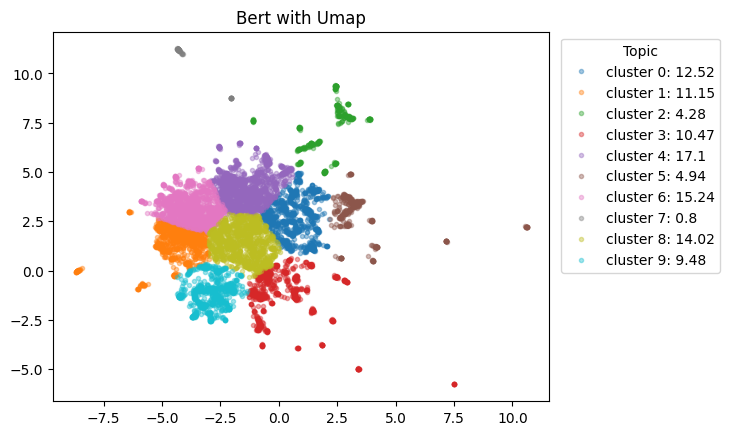

In [ ]:
# umap embeddings
embedding_umap_bert = reduce_umap(embedding_bert)
labels_bert_umap  = predict_topics_with_kmeans(embedding_umap_bert,num_topics)
plot_embeddings(embedding_umap_bert, labels_bert_umap,"Bert with Umap")